 # Autoencoders: 
 In this task, you’ll build and train autoencoder models using the Fashion-MNIST dataset (think shoes, shirts, and bags instead of digits). Set the hidden (latent) dimension to 16 and 48.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data',train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data',train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)


- Autoencoder Implementation for Latent_dim = 16

In [22]:
class Autoencoder(nn.Module):
    def __init__(self,latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),  # latent_dim = 16
            nn.ReLU(), 
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,self.latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x= self.encoder(x)
        x= self.decoder(x)
        return x
    
autoencoder = Autoencoder()

In [33]:
loss_func = nn.MSELoss()
n_epoch = 20
lr = 1e-3
weight_decay=1e-8
outputs=[]
losses=[]
test_output=[]
test_losses=[]
optimizer = optim.Adam(autoencoder.parameters(),lr,weight_decay=weight_decay)
for epoch in range(n_epoch):
    for data,_ in train_loader:
        data = data.view(data.size(0),-1)
        output = autoencoder(data)
        # what parameters are getting updated over here?
        loss = loss_func(output,data)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    
    total_test_loss=0
    autoencoder.eval()
    with torch.no_grad():
        for test_data,_ in test_loader:
            test_data = test_data.view(test_data.size(0),-1)
            output_test = autoencoder(test_data)
            test_loss = loss_func(output_test,test_data)
            total_test_loss += test_loss.item()
            
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    outputs.append((epoch,data,output))
    test_output.append((epoch,test_data,output_test))
    
    print(f'Epoch [{epoch+1}/{n_epoch}], Train Loss: {loss.item():.4f}, , Test Loss: {test_loss.item():.4f}')
        

Epoch [1/20], Train Loss: 0.0185, , Test Loss: 0.0161
Epoch [2/20], Train Loss: 0.0161, , Test Loss: 0.0179
Epoch [3/20], Train Loss: 0.0173, , Test Loss: 0.0164
Epoch [4/20], Train Loss: 0.0170, , Test Loss: 0.0144
Epoch [5/20], Train Loss: 0.0171, , Test Loss: 0.0158
Epoch [6/20], Train Loss: 0.0160, , Test Loss: 0.0171
Epoch [7/20], Train Loss: 0.0153, , Test Loss: 0.0141
Epoch [8/20], Train Loss: 0.0163, , Test Loss: 0.0155
Epoch [9/20], Train Loss: 0.0165, , Test Loss: 0.0195
Epoch [10/20], Train Loss: 0.0172, , Test Loss: 0.0204
Epoch [11/20], Train Loss: 0.0143, , Test Loss: 0.0186
Epoch [12/20], Train Loss: 0.0153, , Test Loss: 0.0139
Epoch [13/20], Train Loss: 0.0160, , Test Loss: 0.0170
Epoch [14/20], Train Loss: 0.0162, , Test Loss: 0.0181
Epoch [15/20], Train Loss: 0.0154, , Test Loss: 0.0133
Epoch [16/20], Train Loss: 0.0163, , Test Loss: 0.0132
Epoch [17/20], Train Loss: 0.0144, , Test Loss: 0.0155
Epoch [18/20], Train Loss: 0.0141, , Test Loss: 0.0143
Epoch [19/20], Trai

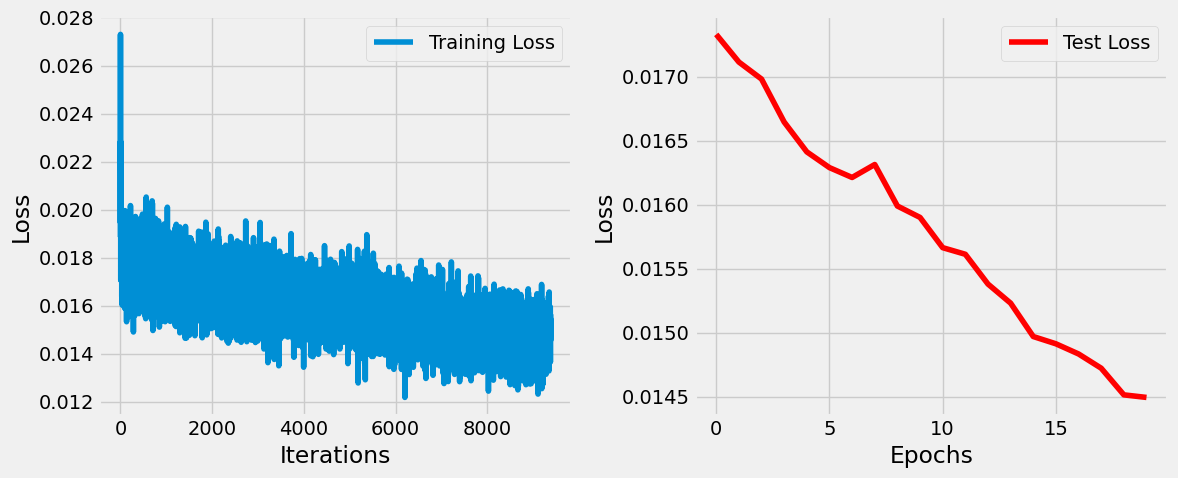

In [34]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 5))

# Training loss (per iteration)
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# Test loss (per epoch)
plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
def plot_ae_outputs(outputs, n=10, epochs=50):
    plt.figure(figsize=(16, 4.5))
    
    selected_epochs = list(range(0, epochs, epochs//n))
    if len(selected_epochs) < n:  
        selected_epochs.append(epochs-1)
    if len(selected_epochs) > n:  # If we have too many, trim
        selected_epochs = selected_epochs[:n]
    
    selected_outputs = [outputs[i] for i in selected_epochs]
    
    for i, (epoch, img, rec_img) in enumerate(selected_outputs):
        # Plot original image
        ax = plt.subplot(2, n, i+1)
        plt.imshow(img[0].reshape(28, 28).detach().numpy(), cmap='gray') 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'Epoch {epoch+1}')
        
        # Plot reconstructed image
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(rec_img[0].reshape(28, 28).detach().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # Add row titles
    plt.figtext(0.5, 0.95, 'Original Images', ha='center', va='center', fontsize=12)
    plt.figtext(0.5, 0.45, 'Reconstructed Images', ha='center', va='center', fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for row titles
    plt.show()

- train output of latent_dim=16

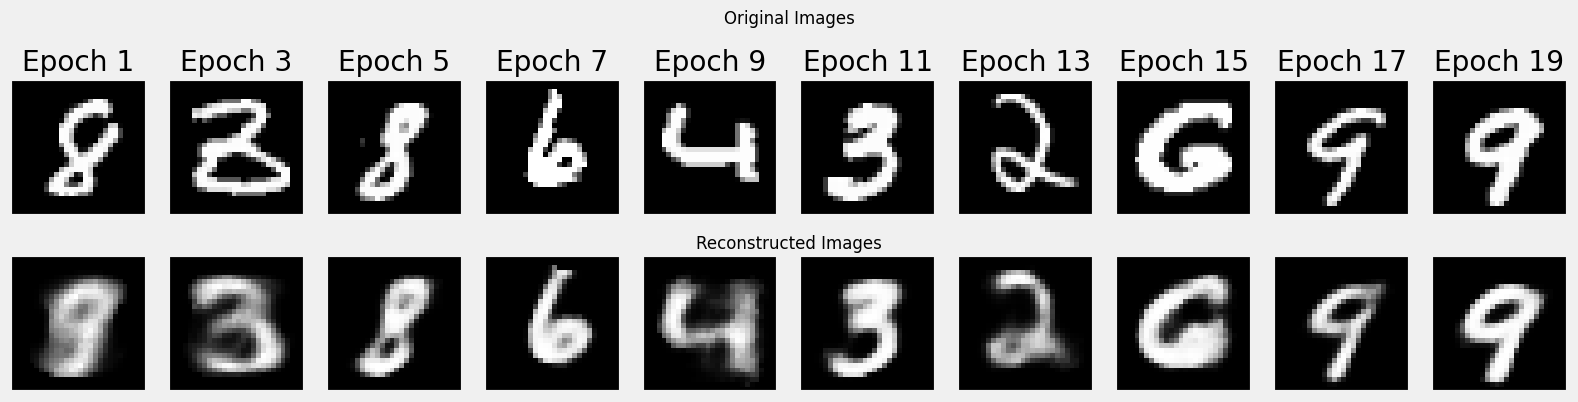

In [26]:
plot_ae_outputs(outputs, n=10, epochs=20)

# Observation
- In the early epochs (e.g., Epochs 1–5), the reconstructed images are blurry and lack clear digit structure, indicating that the model is just beginning to learn the mapping from input to output.
- As training progresses, the reconstructions become sharper and more closely resemble the originals at the later epochs from (15-19).
- Some digits (like '2' and '6') are reconstructed with minor distortions even in later epochs

- test output of latent_dim=16

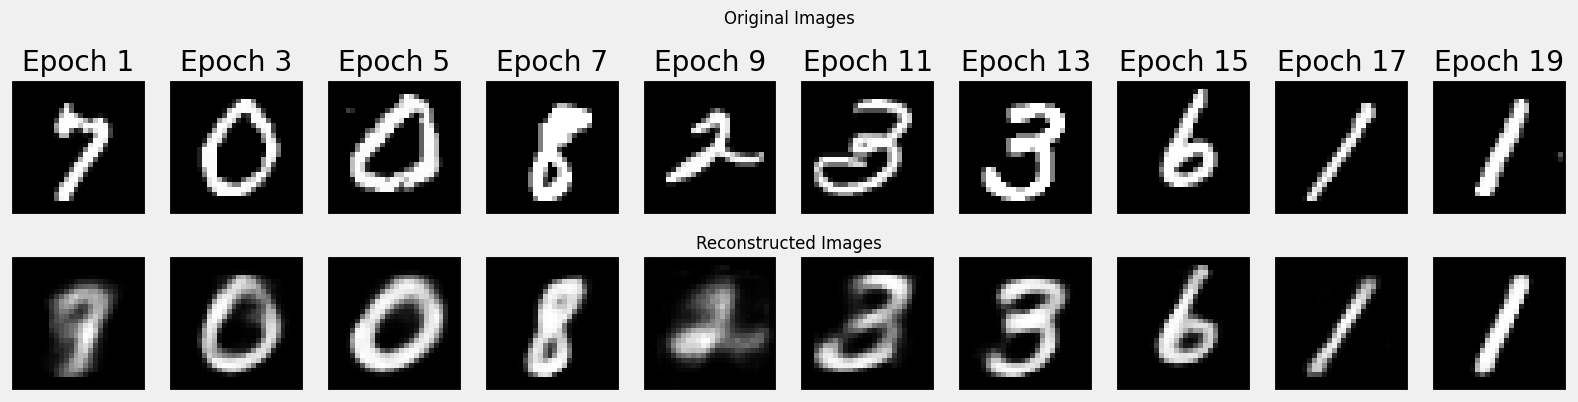

In [27]:
plot_ae_outputs(test_output, n=10, epochs=20)

- Autoencoder implementation when latent_dim = 48

In [17]:
from torch.utils.data import DataLoader
class AutoEncoder(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28,512), 
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,self.latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,784),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 
    

autoencoder_48 = AutoEncoder(latent_dim=48)

In [28]:
criterion = nn.MSELoss()
lr=1e-3
optimizer = optim.Adam(autoencoder_48.parameters(),lr=lr)
trainloader = DataLoader(train_dataset,shuffle=True,batch_size=128)
testloader = DataLoader(test_dataset,shuffle=True,batch_size=128)

losses=[]
final_output=[]
n_epoch=20
test_output=[]
test_losses=[]

for epoch in range(n_epoch):
    for data,_ in trainloader:
        data = data.view(data.size(0),-1)
        output = autoencoder_48.forward(data)
        loss = criterion(data,output)
        # backprop
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    autoencoder_48.eval()
    total_test_loss=0
    with torch.no_grad():
        for test_images, _ in testloader:
            test_images = test_images.view(test_images.size(0),-1)
            reconstructed_test = autoencoder_48.forward(test_images)
            test_loss = criterion(test_images,reconstructed_test)
            total_test_loss += test_loss.item()
            
    avg_test_loss = total_test_loss / len(testloader)
    test_losses.append(avg_test_loss)
            
    
    final_output.append((epoch,data,output))
    test_output.append((epoch,test_images,reconstructed_test))
    print(f'Epoch [{epoch+1}/{n_epoch}], Train Loss: {loss.item():.4f} , Test Loss: {test_loss.item():.4f}')

Epoch [1/20], Train Loss: 0.0152 , Test Loss: 0.0153
Epoch [2/20], Train Loss: 0.0140 , Test Loss: 0.0175
Epoch [3/20], Train Loss: 0.0140 , Test Loss: 0.0165
Epoch [4/20], Train Loss: 0.0144 , Test Loss: 0.0224
Epoch [5/20], Train Loss: 0.0139 , Test Loss: 0.0134
Epoch [6/20], Train Loss: 0.0151 , Test Loss: 0.0110
Epoch [7/20], Train Loss: 0.0140 , Test Loss: 0.0166
Epoch [8/20], Train Loss: 0.0119 , Test Loss: 0.0165
Epoch [9/20], Train Loss: 0.0132 , Test Loss: 0.0147
Epoch [10/20], Train Loss: 0.0117 , Test Loss: 0.0130
Epoch [11/20], Train Loss: 0.0128 , Test Loss: 0.0139
Epoch [12/20], Train Loss: 0.0107 , Test Loss: 0.0130
Epoch [13/20], Train Loss: 0.0124 , Test Loss: 0.0129
Epoch [14/20], Train Loss: 0.0112 , Test Loss: 0.0138
Epoch [15/20], Train Loss: 0.0108 , Test Loss: 0.0116
Epoch [16/20], Train Loss: 0.0095 , Test Loss: 0.0117
Epoch [17/20], Train Loss: 0.0118 , Test Loss: 0.0128
Epoch [18/20], Train Loss: 0.0108 , Test Loss: 0.0131
Epoch [19/20], Train Loss: 0.0100 , T

- train test plot

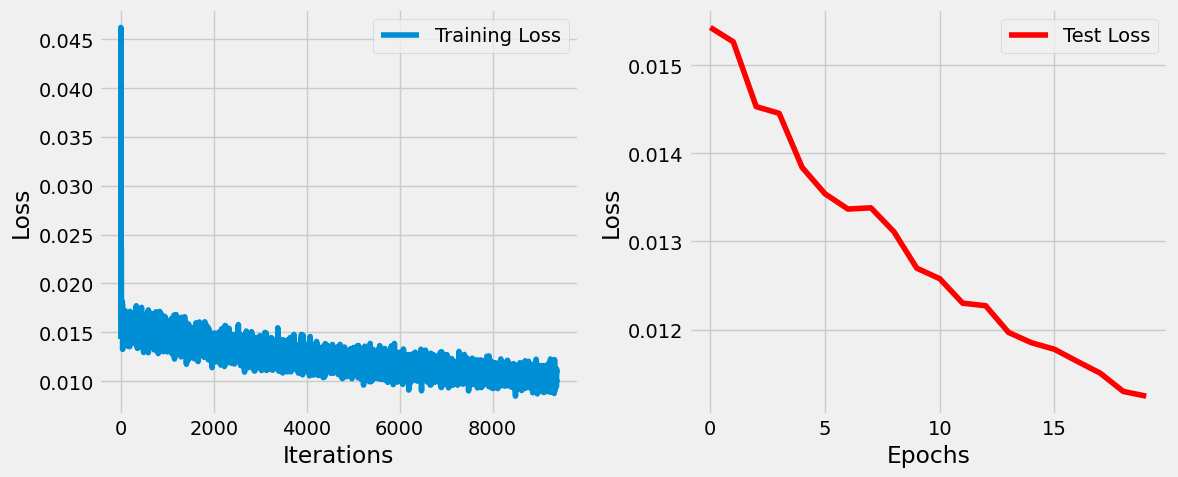

In [30]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 5))

# Training loss (per iteration)
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# Test loss (per epoch)
plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

- test loss of latent_dim=48

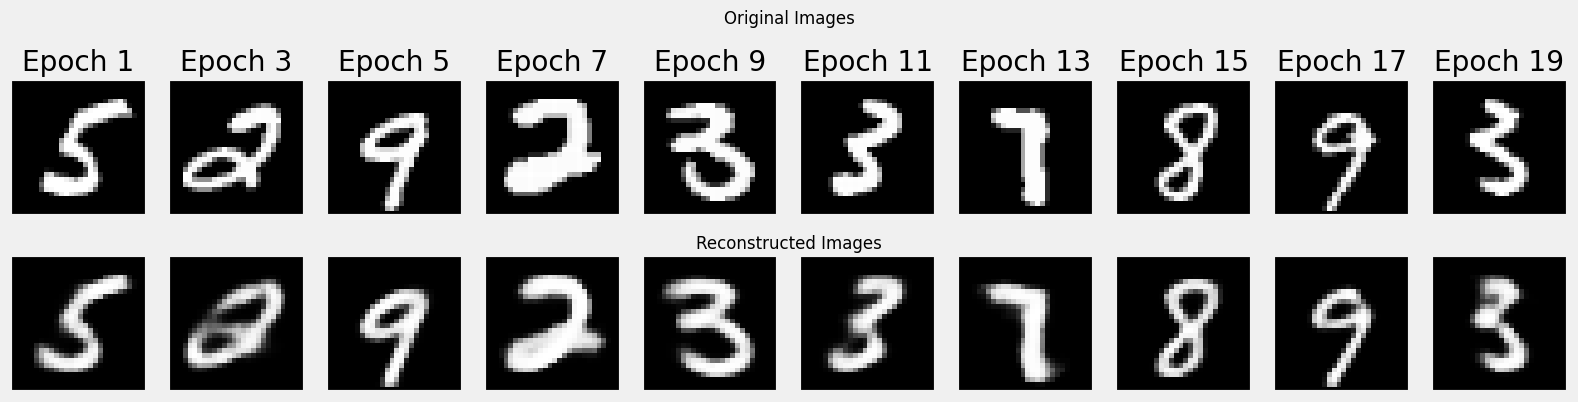

In [31]:
plot_ae_outputs(test_output, n=10, epochs=20)

- train loss of latent_dim=48

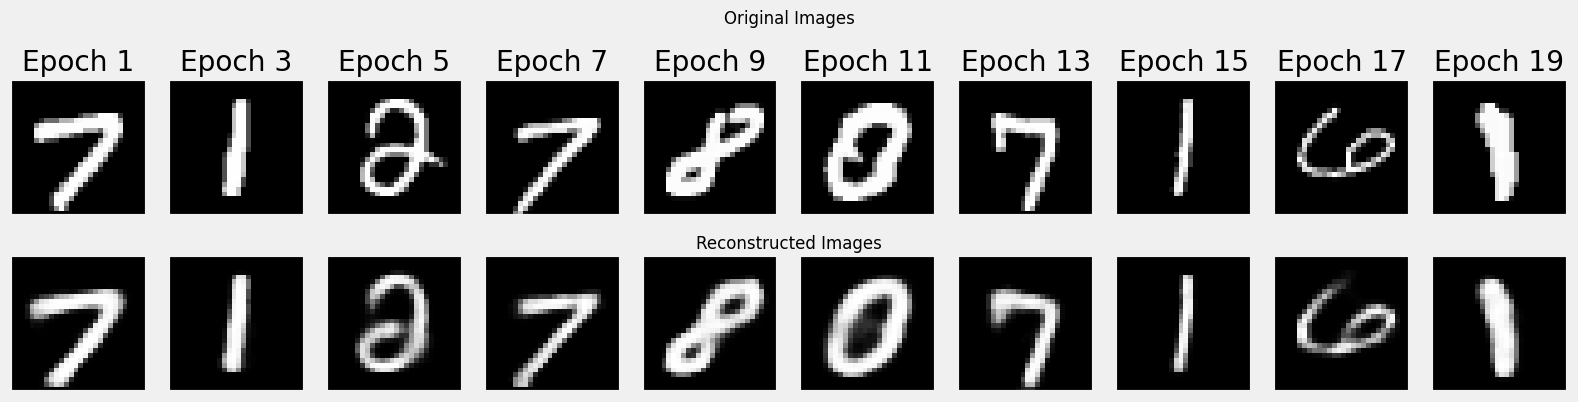

In [32]:
plot_ae_outputs(final_output, n=10, epochs=20)

b. Pick 4 pairs of training samples. In the latent space, interpolate between each pair by taking 5 evenly spaced points along the line connecting their latent representations. Decode these points and display the resulting images. What trends do you notice as you move between samples?

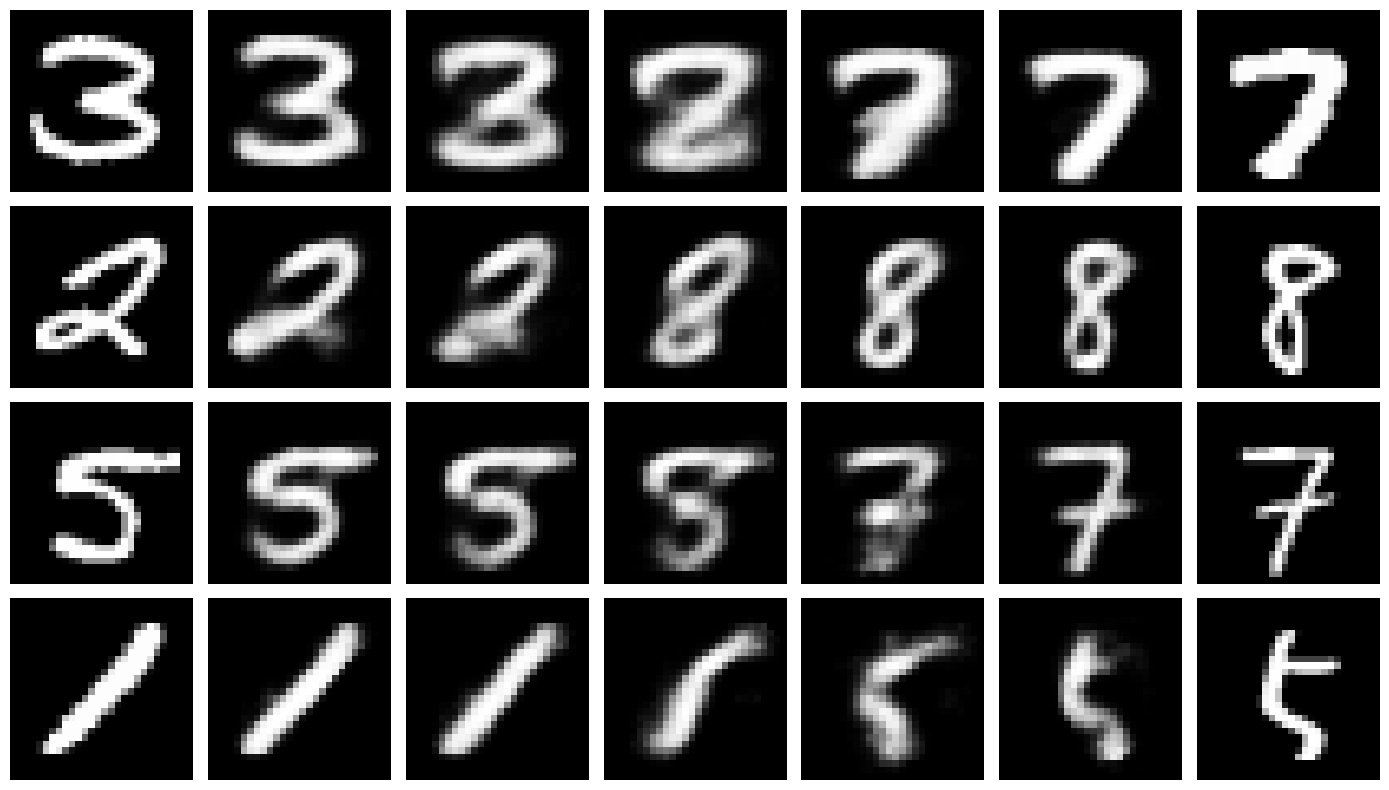

In [129]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training samples
batch_iter = iter(train_loader)
images, _ = next(batch_iter)
images = images.view(images.size(0), -1)

# Select 8 images (4 pairs)
selected_indices = [0, 1, 2, 3, 4, 5, 6, 7]
sample_images = images[selected_indices]

# Get latent representations
with torch.no_grad():
    latents = autoencoder_48.encoder(sample_images)

# Create interpolation points for each pair
results = []
for i in range(0, 8, 2):
    start_latent = latents[i]
    end_latent = latents[i+1]
    
    # Create 5 interpolation points
    alphas = np.linspace(0, 1, 5)
    interpolated_points = []
    
    for alpha in alphas:
        # Linear interpolation: z = (1-α)×z₁ + α×z₂
        interp = (1-alpha) * start_latent + alpha * end_latent
        interpolated_points.append(interp)
    
    # Decode interpolated points
    decoded_images = []
    for point in interpolated_points:
        with torch.no_grad():
            decoded = autoencoder_48.decoder(point.unsqueeze(0)).squeeze(0)
            decoded_images.append(decoded)
    
    results.append({
        'start': sample_images[i],
        'end': sample_images[i+1],
        'interpolations': decoded_images
    })

# Visualize results
fig, axes = plt.subplots(4, 7, figsize=(14, 8))
for i, result in enumerate(results):
    # Display original start image
    start_img = result['start'].view(28, 28).cpu().detach().numpy()
    axes[i, 0].imshow(start_img, cmap='gray')
    axes[i, 0].axis('off')
    
    # Display interpolations
    for j, img in enumerate(result['interpolations']):
        img_np = img.view(28, 28).cpu().detach().numpy()
        axes[i, j+1].imshow(img_np, cmap='gray')
        axes[i, j+1].axis('off')
    
    # Display original end image
    end_img = result['end'].view(28, 28).cpu().detach().numpy()
    axes[i, 6].imshow(end_img, cmap='gray')
    axes[i, 6].axis('off')

plt.tight_layout()
plt.show()


## Variational Autoencoder(VAE): 
Train a Variational Autoencoder (VAE) on the Fashion MNIST dataset to generate new clothing-like images. Design the encoder to output a distribution in a 12-dimensional latent space.

In [ ]:

from torch.nn import init
class Encoder(nn.Module):
    def __init__(self,input,hidden,latent):
        super().__init__()
        self.fc1 = nn.Linear(input,hidden)
        self.logvar = nn.Linear(hidden,latent)
        self.mu = nn.Linear(hidden,latent)
        self.dropout = nn.Dropout(0.3)
        self.bn1= nn.BatchNorm1d(hidden)
        self.initialize_weight()
        
    def initialize_weight(self):
        init.xavier_uniform_(self.fc1.weight)
        init.zeros_(self.fc1.bias)
        
        init.xavier_uniform_(self.logvar.weight)
        init.zeros_(self.logvar.bias)
        
        init.xavier_uniform_(self.mu.weight)
        init.zeros_(self.mu.bias)
    
    def forward(self,x):
        
        h = self.fc1(x)
        h = self.bn1(h)
        h = torch.relu(h)
        h=self.dropout(h)
        logvar = self.logvar(h)
        mu = self.mu(h)
        return logvar,mu
    
class Decoder(nn.Module):
    def __init__(self,latent,hidden,output):
        super().__init__()
        self.fc1 = nn.Linear(latent,hidden)
        self.fc2 = nn.Linear(hidden,output)
        self.dropout = nn.Dropout(0.3)
        self.init_weights()
        
    def init_weights(self):
        init.xavier_uniform_(self.fc1.weight)
        init.zeros_(self.fc1.bias)
        
        init.xavier_uniform_(self.fc2.weight)
        init.zeros_(self.fc2.bias)
    
    def forward(self,z):
        h = torch.relu(self.fc1(z))
        h = self.dropout(h)
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat
        
    
class VAE(nn.Module):
    def __init__(self,input,hidden,latent):
        super().__init__()
        self.encoder = Encoder(input,hidden,latent)
        self.decoder = Decoder(latent,hidden,input)
    
    def forward(self,x):
        logvar,mu = self.encoder(x)
        
        #reparamaterization trick
        std=torch.exp(0.5*logvar) 
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_hat = self.decoder(z)

        return x_hat,mu,logvar
    

In [89]:
def loss_function(x,x_hat,mu,logvar):
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE+KLD

In [ ]:
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the images
])

# Load MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [116]:
input=28*28
hidden_dim = 400
latent_dim = 12
lr = 1e-3
num_epochs = 20

variational_autoencoder= VAE(input,hidden_dim,latent_dim)

# define optimizer 
optimizer = optim.Adam(variational_autoencoder.parameters(),lr=lr)

In [ ]:
outputs=[]
for epoch in range(num_epochs):
    variational_autoencoder.train()
    train_loss=0
    for data,_ in train_loader:
        optimizer.zero_grad()
        x_hat,mu,logvar=variational_autoencoder(data)
        loss = loss_function(data,x_hat,mu,logvar)
        loss.backward()
        train_loss+=loss
        optimizer.step()
    outputs.append(loss.item())
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 0, Loss: 291.5680
Epoch 1, Loss: 263.1317
Epoch 2, Loss: 258.5377
Epoch 3, Loss: 256.2261
Epoch 4, Loss: 254.8367
Epoch 5, Loss: 253.9533
Epoch 6, Loss: 253.2372
Epoch 7, Loss: 252.6882
Epoch 8, Loss: 252.1624
Epoch 9, Loss: 251.9095
Epoch 10, Loss: 251.4823
Epoch 11, Loss: 251.1984
Epoch 12, Loss: 251.0198
Epoch 13, Loss: 250.7774
Epoch 14, Loss: 250.4859
Epoch 15, Loss: 250.3397
Epoch 16, Loss: 250.2748
Epoch 17, Loss: 250.0685
Epoch 18, Loss: 249.9102
Epoch 19, Loss: 249.8661


b. After training, sample 50 new images from the learned distribution and display them in a grid.Comment on the diversity and quality of the generated samples—are they recognizable as Fashion
MNIST items? 

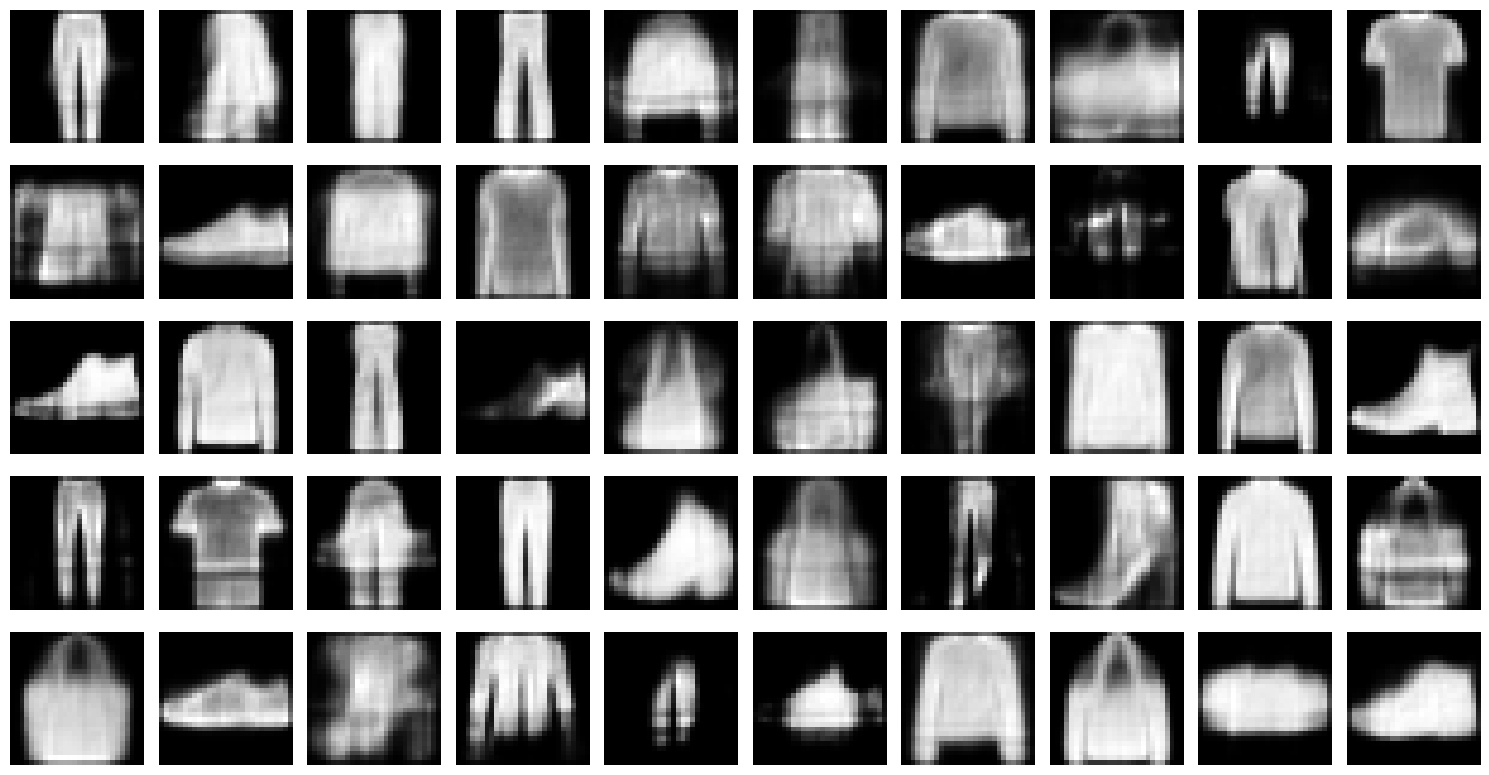

In [ ]:
import torch
import matplotlib.pyplot as plt

variational_autoencoder.eval()
with torch.no_grad():
    z = torch.randn(50, 12)  # 50 samples from 12D standard normal
    samples = variational_autoencoder.decoder(z).cpu().numpy()
    samples = samples.reshape(-1, 28, 28)

fig, axes = plt.subplots(5, 10, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


## Diversity and quality of the generated samples
- **diversity** : with well trained VAE and a 12D latent space, the generated images covers all the MNIST categories images e.g (shirts,trousers,shoes,purse,etc) however these are of low dimensions and shows variations in shape and style.
  
- **quality** : the images are of low-dimensional because of the decoding done but is recognizable as clothing item. However some, samples are ambiguous or less sharp, it is a known limitation of basic VAEs.

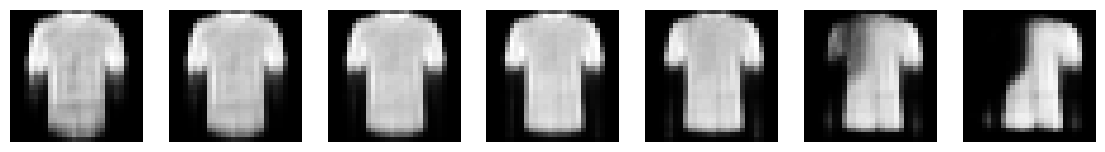

In [ ]:
#latent code visualization
z = torch.randn(1, 12)
fig, axes = plt.subplots(1, 7, figsize=(14, 2))
for i, val in enumerate(torch.linspace(-3, 3, 7)):
    z_mod = z.clone()
    z_mod[0, 0] = val  # tweak first latent dim
    sample = variational_autoencoder.decoder(z_mod).cpu().detach().numpy().reshape(28, 28)
    axes[i].imshow(sample, cmap='gray')
    axes[i].axis('off')
plt.show()


## Latent Variable Manipulation
- **tweak** : systematically vary one dimension ex, from -3 to +3 and decode each modified vector
- **effect** : from the image we can see it is morphed smoothly, VAE has learned disentangled representations to some extent.
  - A latent dimension can control certain generative factors(e.g sleeve length, shoe thickness, etc)